In [118]:
from numpy import linalg as LA
from scipy.stats import chi2
import cmath

In [1]:
import numpy as np

B = np.array([[40, -26], [-26, 25]])

In [2]:
A = np.linalg.cholesky(B)
A@A.T

array([[ 40., -26.],
       [-26.,  25.]])

In [4]:
samples = A @ np.random.randn(2, 1000000)

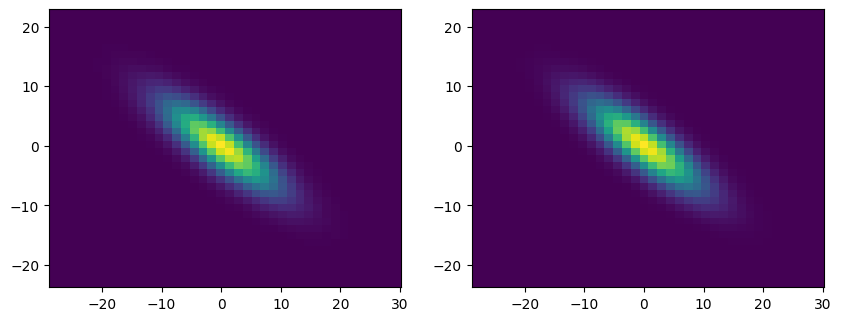

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

h, x, y, _ = ax[0].hist2d(*samples, bins=40)
ax[0].set_aspect('equal')

grid = np.stack(np.meshgrid((x[1:] + x[:-1])/2, (y[1:] + y[:-1])/2))
pdf = multivariate_normal.pdf(grid.reshape(2, -1).T, cov=B).reshape(h.shape)

ax[1].imshow(pdf, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()))
ax[1].set_aspect('equal')

plt.show()

**Выделим одну картинку**

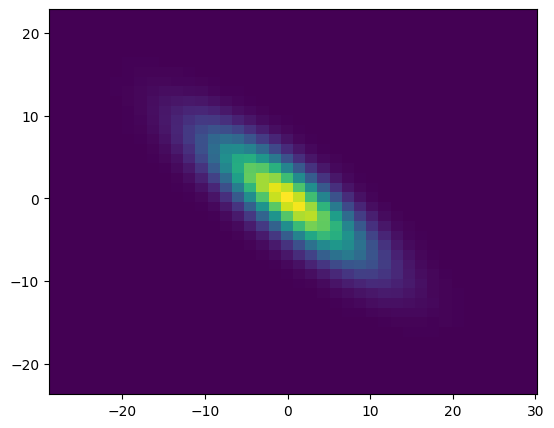

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

h, x, y, _  = ax.hist2d(*samples, bins=40)
ax.set_aspect('equal')

grid = np.stack(np.meshgrid((x[1:] + x[:-1])/2, (y[1:] + y[:-1])/2))
pdf = multivariate_normal.pdf(grid.reshape(2, -1).T, cov=B).reshape(h.shape)


plt.show()


*Общий подход: по матрице ковариации находим необходимые характеристики (собственные векторы, собственные значения), которые естественно зависят от предложенного количества содержащейся плотности, что позволит получить и геометрическую составляющую объекта (полуоси эллипса, центр эллипса). Рисуем эллипс в начале координат, не учитывая его возможный поворот, а далее сдвигаем его и поворачиваем. Это проделываем для каждого %*

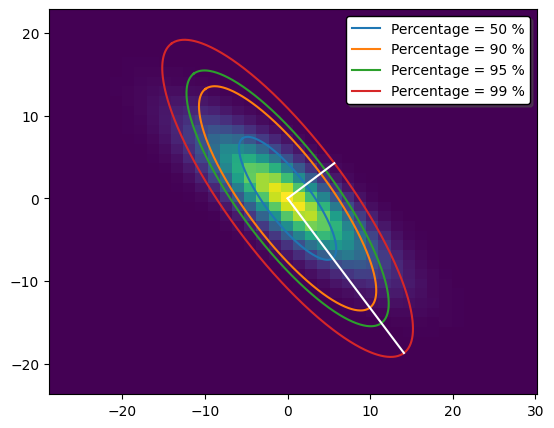

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

h, x, y, _  = ax.hist2d(*samples, bins=40)
ax.set_aspect('equal')

grid = np.stack(np.meshgrid((x[1:] + x[:-1])/2, (y[1:] + y[:-1])/2))
pdf = multivariate_normal.pdf(grid.reshape(2, -1).T, cov=B).reshape(h.shape)

interval = np.arange(0, 2*np.pi, 0.01)

eigenvalues, eigenvectors = LA.eig(B)
np.sort(eigenvalues)[::-1]
eigenvectors = eigenvectors[::-1]
percentage = [50, 90, 95, 99]
chi_2 = []
for j in range(4):
    chi_2.append(chi2.ppf(percentage[j]/100, 2))
    
for j in range(len(chi_2)):
    # сначала получим значения полуосей эллипса
    a = (eigenvalues[0]*chi_2[j])**0.5
    b = (eigenvalues[1]*chi_2[j])**0.5
    x_coord = [a*np.cos(t) for t in interval]
    y_coord = [b*np.sin(t) for t in interval]
    # далее найдем направления этих полуосей
    a_v = a*eigenvectors[0]
    b_v = b*eigenvectors[1]
    # следим за поворотом большой полуоси, она определит поворот эллипса, расположенного канонически
    z = complex(a_v[0], a_v[1])
    angle = np.angle(z)
    # производим поворот
    length = len(interval)
    for i in range(length):
        point_x = x_coord[i]
        point_y = y_coord[i]
        x_coord[i] = point_x*np.cos(angle) - point_y*np.sin(angle)
        y_coord[i] = point_x*np.sin(angle) + point_y*np.cos(angle)
    # рисуем повернутые эллипсы
    ax.plot(x_coord, y_coord, label='Percentage = {} %'.format(percentage[j]))
    plt.legend(fontsize=10, shadow=True, framealpha=1, edgecolor='black')
    # случай с 99 % - находим векторы полуосей
    if (j == len(chi_2)-1):
        v1 = (chi_2[-1]*eigenvalues[0])**0.5*eigenvectors[0]
        v2 = (chi_2[-1]*eigenvalues[1])**0.5*eigenvectors[1]
        point1_x = [0, -v1[0]]
        point1_y = [0, -v1[1]]
        point2_x = [0, v2[0]]
        point2_y = [0, v2[1]]
        plt.plot(point1_x, point1_y, color = 'white')
        plt.plot(point2_x, point2_y, color = 'white')
plt.show()


Комментарий: честно шел в соответствии с алгоритмом на сайте, но почему-то эллипсы немного не докручиваются 
https://geostatisticslessons.com/lessons/errorellipses